# Preper the dataset



## SDNET2018: A benchmark dataset for semantic segmentation of crack images

https://digitalcommons.usu.edu/all_datasets/48/

Methodology
230 images of cracked and non-cracked concrete surfaces (54 bridge decks, 72 walls, 104 pavements) are captured using a 16 MP Nikon digital camera. The bridge decks were located at the Utah State University system, material, and structural health (SMASH) laboratory. The inspected walls belong to Russell/Wanlass Performance Hall building located on USU campus The pavement images were acquired from the roads and sidewalks on USU campus. Each image is segmented into 256 ◊ 256 px subimages. Each subimage is labeled as C if there was crack in the subimage or U if there was not a crack.

## DeepCrack

https://github.com/yhlleo/DeepCrack

We established a public benchmark dataset with cracks in multiple scales and scenes to evaluate the crack detection systems. All of the crack images in our dataset are manually annotated.

Please note that we own the copyrights to part of original crack images and all annotated maps. Their use is RESTRICTED to non-commercial research and educational purposes.

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, random_split
from PIL import Image
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet101


# Defin the dataset

In [2]:
class CrackDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.images = os.listdir(img_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('.jpg', '.png'))
        
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")
        
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        
        return image, mask.squeeze().long()

In [3]:
def visualize_batch_sample(loader):
    images, masks = next(iter(loader))
    
    idx = 0
    image = images[idx]
    mask = masks[idx]

    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    
    image = (image.numpy() * 255).astype(np.uint8)
    mask = mask.numpy().astype(np.uint8)
    
    image = np.transpose(image, (1, 2, 0))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.imshow(image)
    ax1.set_title(f"Original Image")
    ax1.axis('off')

    ax2.imshow(mask, cmap='gray')
    ax2.set_title("Mask")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")
    
# Define the transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [4]:
# Create the dataset
train_dataset = CrackDataset('dataset/DeepCrack/train_img', 'dataset/DeepCrack/train_lab', transform=transform, mask_transform=mask_transform)
test_dataset = CrackDataset('dataset/DeepCrack/test_img', 'dataset/DeepCrack/test_lab', transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

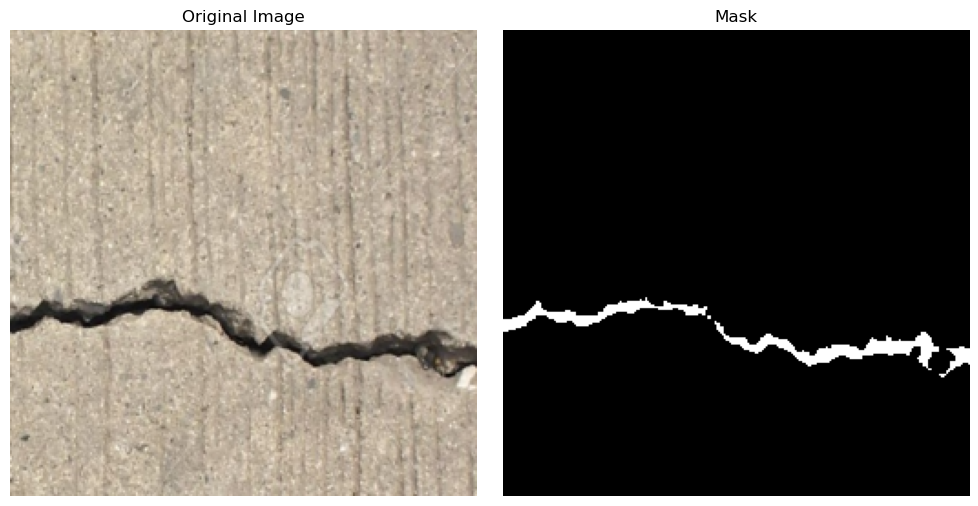

Image shape: (256, 256, 3)
Mask shape: (256, 256)


In [5]:
# Visualize a batch of samples
visualize_batch_sample(train_loader)

In [6]:
torch.cuda.empty_cache()
# define the model
model = deeplabv3_resnet101(pretrained=True)
model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1), stride=(1, 1)) # change the number of classes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# define the loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

c:\Users\brdgadmin\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\brdgadmin\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Train the network

In [7]:
# create a TensorBoard writer
writer = SummaryWriter('runs/crack_detection-deeplab-v3')

num_epochs = 50
total_start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    epoch_start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for i, (images, masks) in enumerate(progress_bar):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        if i % 100 == 99:
            writer.add_scalar('training loss',
                              running_loss / 100,
                              epoch * len(train_loader) + i)
            running_loss = 0.0

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Time: {epoch_duration:.2f}s")

    writer.add_scalar('epoch loss', epoch_loss, epoch)

total_end_time = time.time()
total_duration = total_end_time - total_start_time

print(f"Training finished! Total time: {total_duration:.2f}s")

# 保存模型
torch.save(model.state_dict(), 'crack_segmentation_model.pth')

# 关闭 TensorBoard 写入器
writer.close()

Epoch 1/50: 100%|██████████| 21/21 [00:11<00:00,  1.80it/s, loss=0.5401]


Epoch [1/50], Loss: 0.6747, Time: 11.69s


Epoch 2/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.4071]


Epoch [2/50], Loss: 0.4431, Time: 9.39s


Epoch 3/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.2945]


Epoch [3/50], Loss: 0.3328, Time: 9.44s


Epoch 4/50: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, loss=0.2391]


Epoch [4/50], Loss: 0.2705, Time: 9.48s


Epoch 5/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.2150]


Epoch [5/50], Loss: 0.2260, Time: 9.46s


Epoch 6/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.1757]


Epoch [6/50], Loss: 0.1966, Time: 9.45s


Epoch 7/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.1532]


Epoch [7/50], Loss: 0.1673, Time: 9.46s


Epoch 8/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.1389]


Epoch [8/50], Loss: 0.1468, Time: 9.46s


Epoch 9/50: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, loss=0.1238]


Epoch [9/50], Loss: 0.1324, Time: 9.50s


Epoch 10/50: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s, loss=0.1144]


Epoch [10/50], Loss: 0.1173, Time: 9.55s


Epoch 11/50: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, loss=0.1110]


Epoch [11/50], Loss: 0.1049, Time: 9.50s


Epoch 12/50: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, loss=0.0948]


Epoch [12/50], Loss: 0.0959, Time: 9.52s


Epoch 13/50: 100%|██████████| 21/21 [00:09<00:00,  2.16it/s, loss=0.0834]


Epoch [13/50], Loss: 0.0871, Time: 9.71s


Epoch 14/50: 100%|██████████| 21/21 [00:09<00:00,  2.17it/s, loss=0.0827]


Epoch [14/50], Loss: 0.0801, Time: 9.70s


Epoch 15/50: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s, loss=0.0727]


Epoch [15/50], Loss: 0.0751, Time: 9.58s


Epoch 16/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.0722]


Epoch [16/50], Loss: 0.0694, Time: 9.45s


Epoch 17/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.0610]


Epoch [17/50], Loss: 0.0667, Time: 9.46s


Epoch 18/50: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, loss=0.0654]


Epoch [18/50], Loss: 0.0618, Time: 9.50s


Epoch 19/50: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s, loss=0.0570]


Epoch [19/50], Loss: 0.0582, Time: 9.56s


Epoch 20/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0571]


Epoch [20/50], Loss: 0.0571, Time: 9.40s


Epoch 21/50: 100%|██████████| 21/21 [00:09<00:00,  2.20it/s, loss=0.0561]


Epoch [21/50], Loss: 0.0533, Time: 9.55s


Epoch 22/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0489]


Epoch [22/50], Loss: 0.0502, Time: 9.33s


Epoch 23/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.0423]


Epoch [23/50], Loss: 0.0482, Time: 9.46s


Epoch 24/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0480]


Epoch [24/50], Loss: 0.0457, Time: 9.35s


Epoch 25/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.0502]


Epoch [25/50], Loss: 0.0445, Time: 9.39s


Epoch 26/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0481]


Epoch [26/50], Loss: 0.0429, Time: 9.43s


Epoch 27/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.0398]


Epoch [27/50], Loss: 0.0409, Time: 9.37s


Epoch 28/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0441]


Epoch [28/50], Loss: 0.0411, Time: 9.33s


Epoch 29/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0403]


Epoch [29/50], Loss: 0.0387, Time: 9.40s


Epoch 30/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0421]


Epoch [30/50], Loss: 0.0380, Time: 9.35s


Epoch 31/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.0401]


Epoch [31/50], Loss: 0.0368, Time: 9.39s


Epoch 32/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.0322]


Epoch [32/50], Loss: 0.0353, Time: 9.47s


Epoch 33/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0341]


Epoch [33/50], Loss: 0.0345, Time: 9.44s


Epoch 34/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0358]


Epoch [34/50], Loss: 0.0331, Time: 9.41s


Epoch 35/50: 100%|██████████| 21/21 [00:09<00:00,  2.19it/s, loss=0.0384]


Epoch [35/50], Loss: 0.0328, Time: 9.59s


Epoch 36/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0388]


Epoch [36/50], Loss: 0.0315, Time: 9.34s


Epoch 37/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0310]


Epoch [37/50], Loss: 0.0306, Time: 9.32s


Epoch 38/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0274]


Epoch [38/50], Loss: 0.0301, Time: 9.35s


Epoch 39/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0321]


Epoch [39/50], Loss: 0.0294, Time: 9.32s


Epoch 40/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0315]


Epoch [40/50], Loss: 0.0290, Time: 9.36s


Epoch 41/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0288]


Epoch [41/50], Loss: 0.0289, Time: 9.42s


Epoch 42/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.0249]


Epoch [42/50], Loss: 0.0276, Time: 9.36s


Epoch 43/50: 100%|██████████| 21/21 [00:09<00:00,  2.24it/s, loss=0.0288]


Epoch [43/50], Loss: 0.0272, Time: 9.40s


Epoch 44/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0257]


Epoch [44/50], Loss: 0.0263, Time: 9.32s


Epoch 45/50: 100%|██████████| 21/21 [00:09<00:00,  2.23it/s, loss=0.0251]


Epoch [45/50], Loss: 0.0266, Time: 9.41s


Epoch 46/50: 100%|██████████| 21/21 [00:09<00:00,  2.27it/s, loss=0.0214]


Epoch [46/50], Loss: 0.0255, Time: 9.27s


Epoch 47/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0259]


Epoch [47/50], Loss: 0.0253, Time: 9.34s


Epoch 48/50: 100%|██████████| 21/21 [00:09<00:00,  2.25it/s, loss=0.0244]


Epoch [48/50], Loss: 0.0247, Time: 9.31s


Epoch 49/50: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s, loss=0.0300]


Epoch [49/50], Loss: 0.0246, Time: 9.47s


Epoch 50/50: 100%|██████████| 21/21 [00:09<00:00,  2.26it/s, loss=0.0229]


Epoch [50/50], Loss: 0.0244, Time: 9.30s
Training finished! Total time: 473.77s


Mean IoU: 0.5325


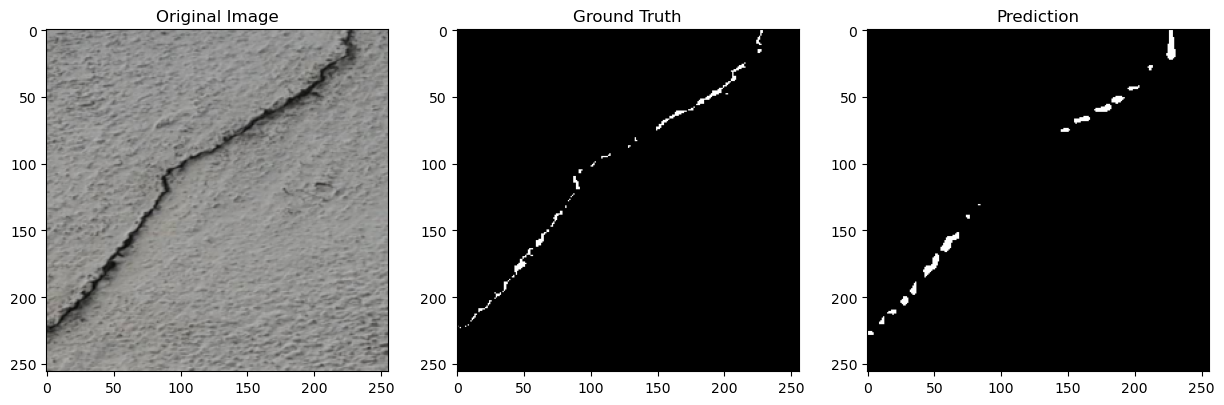

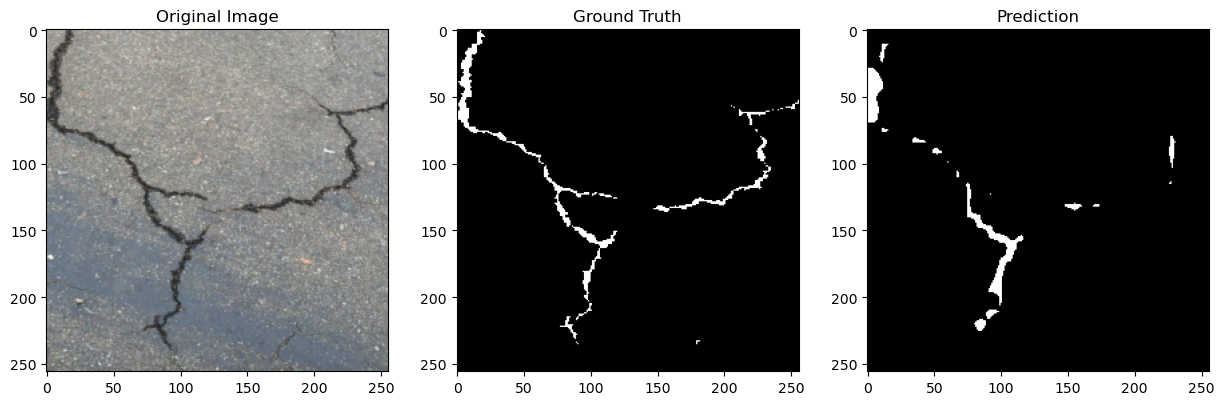

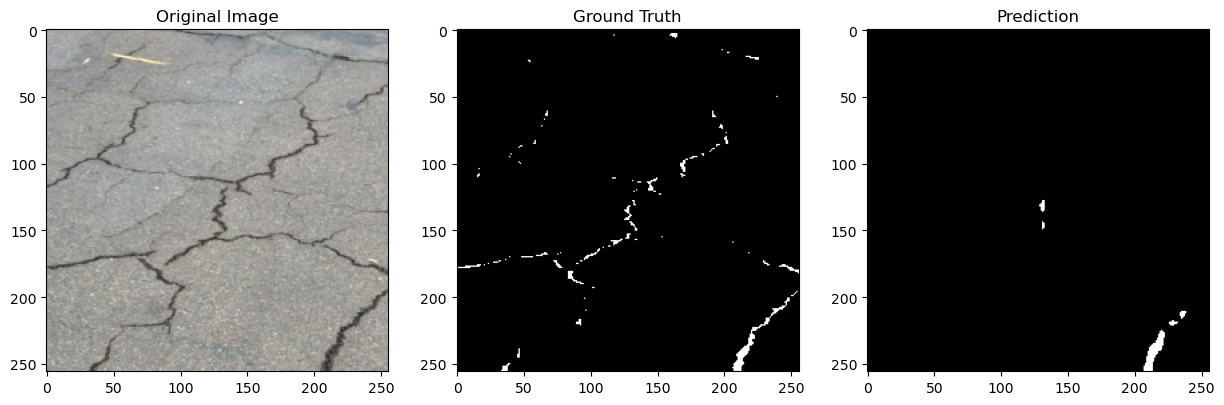

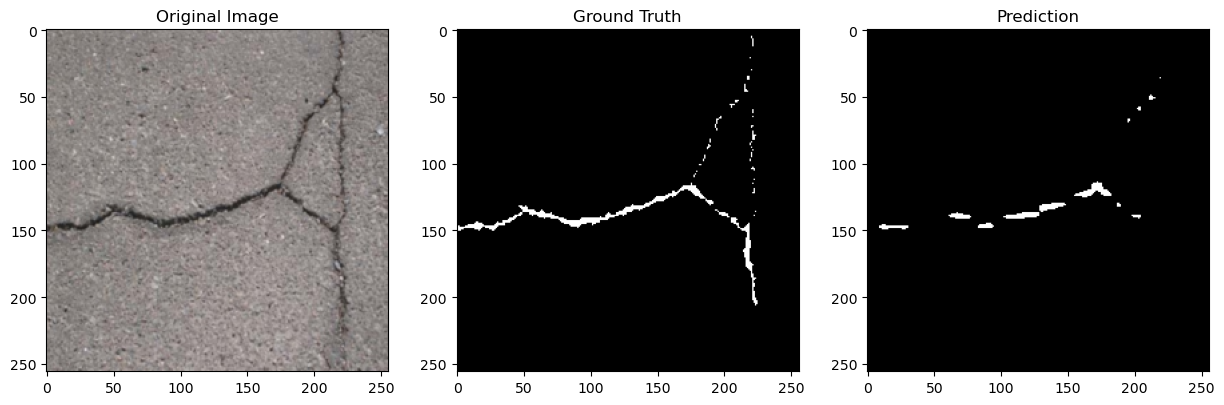

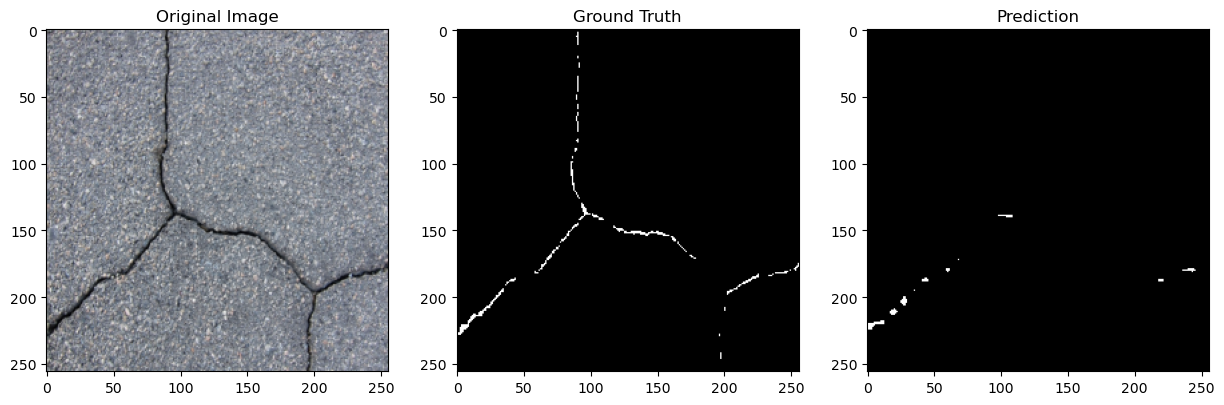

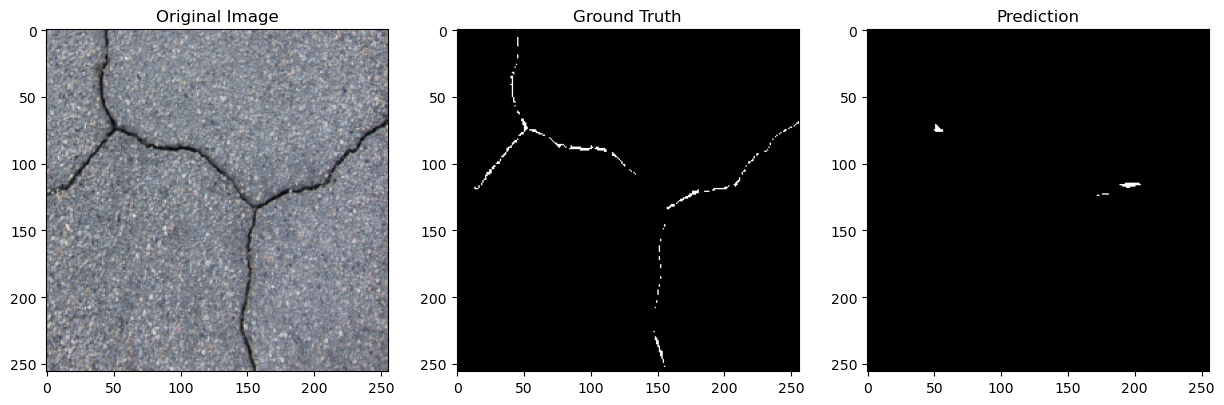

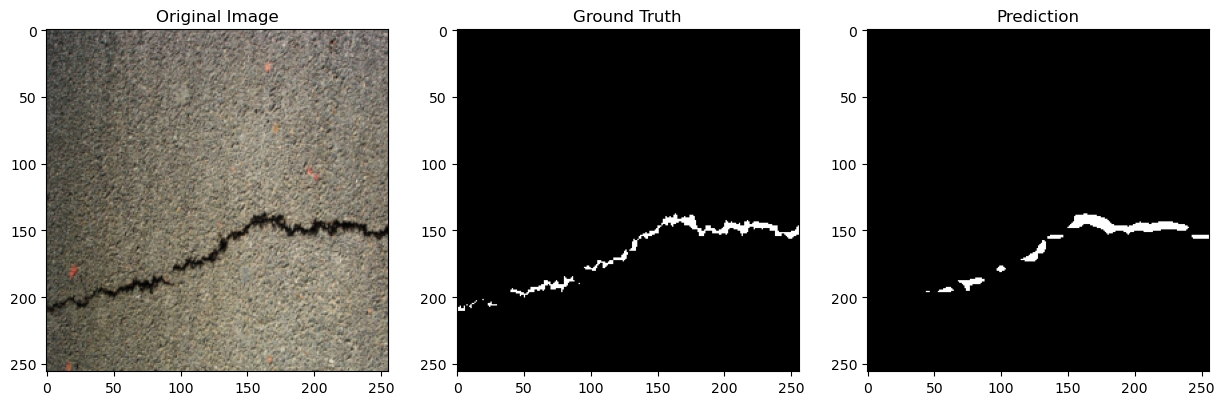

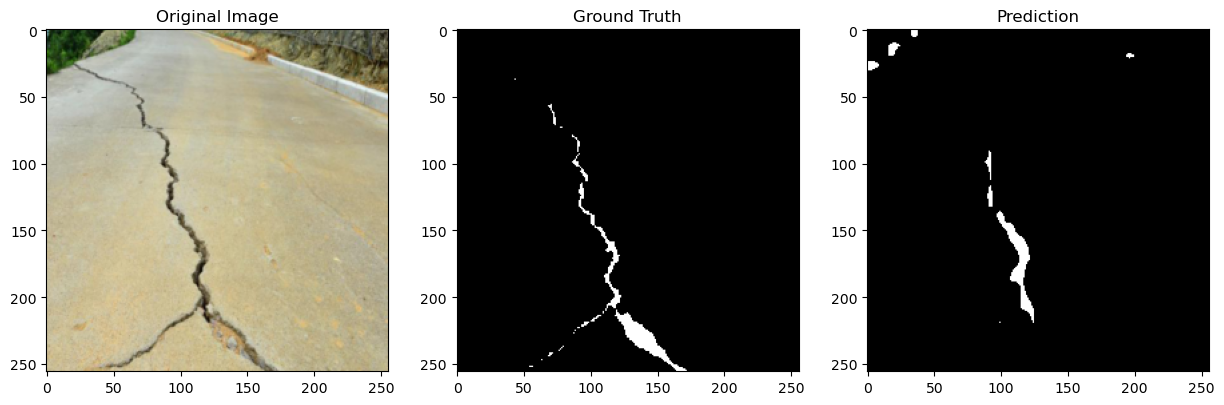

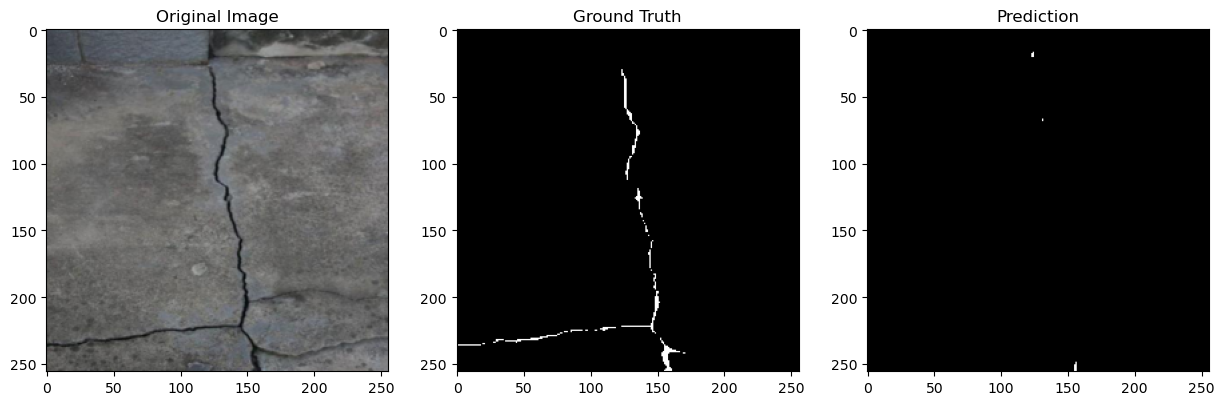

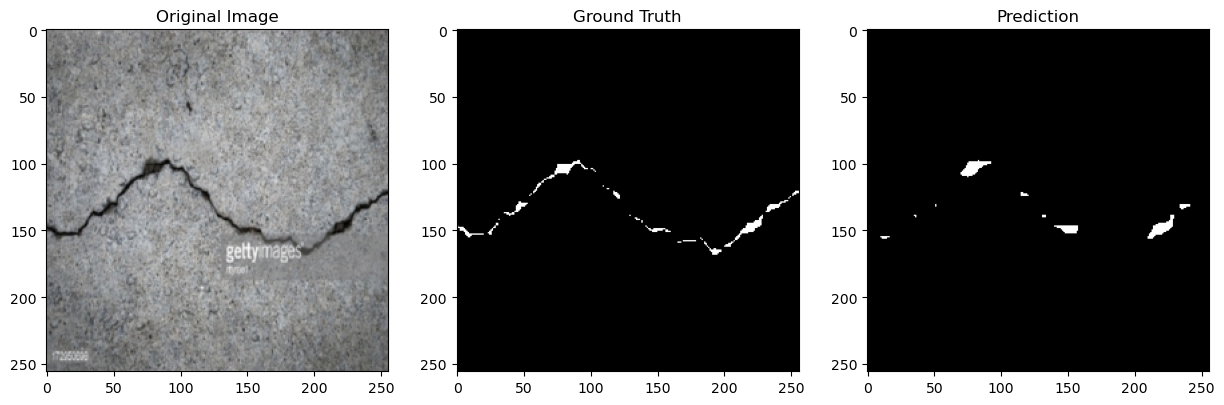

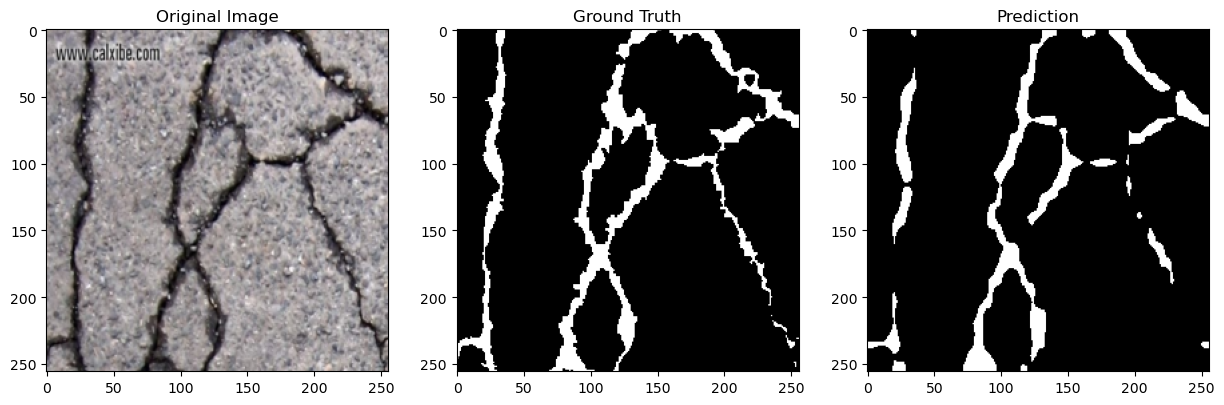

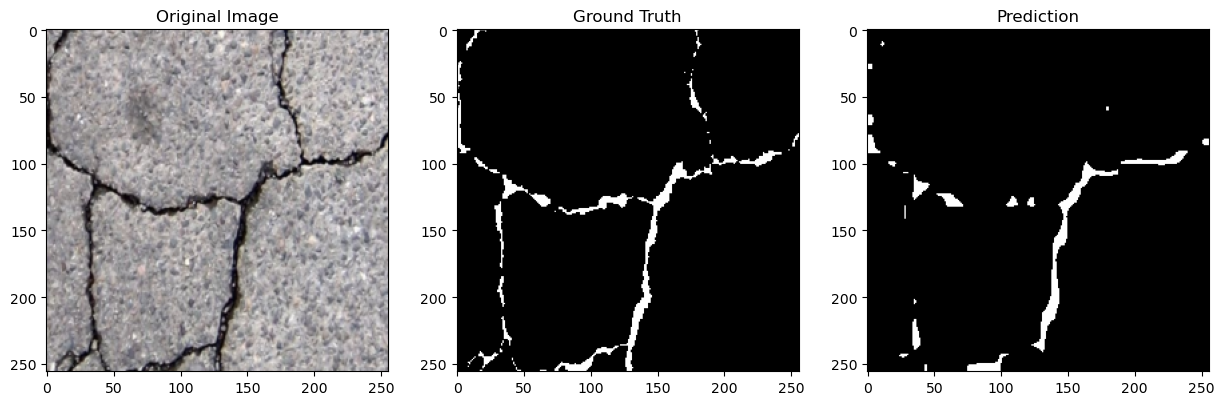

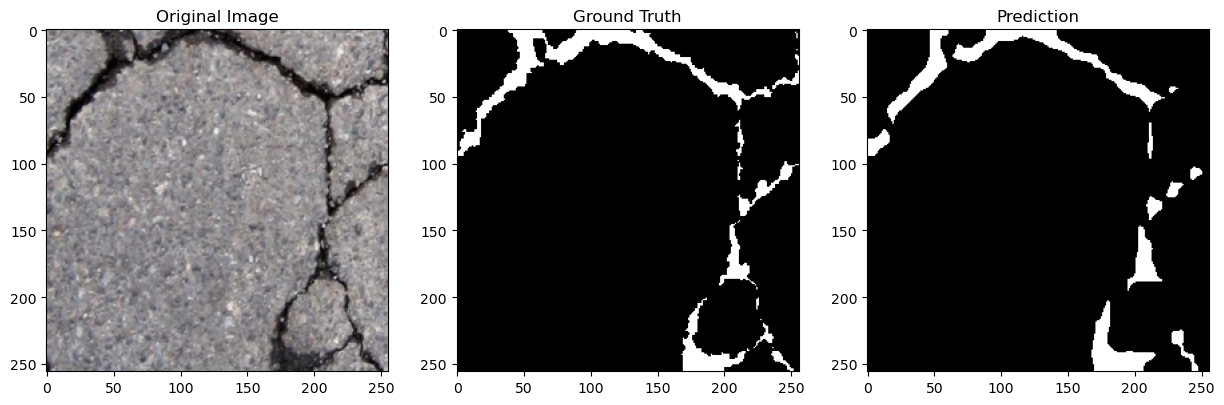

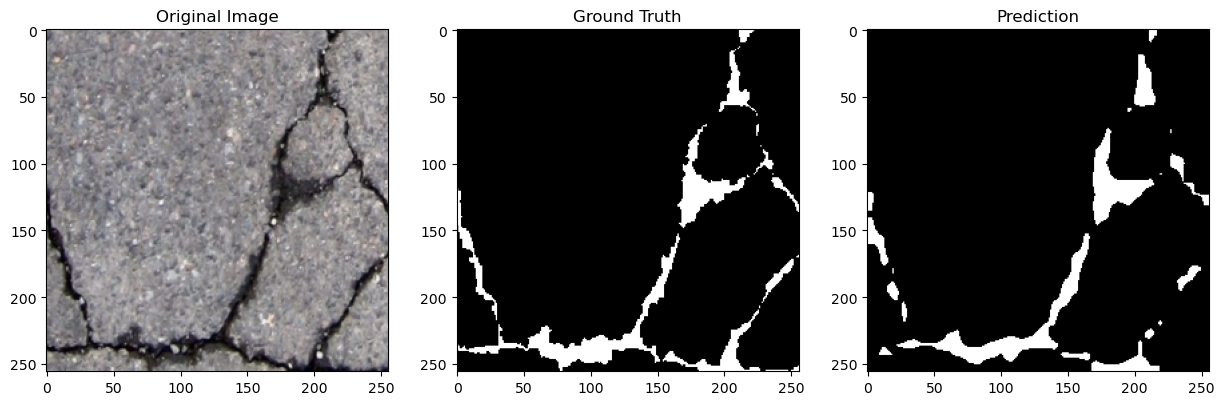

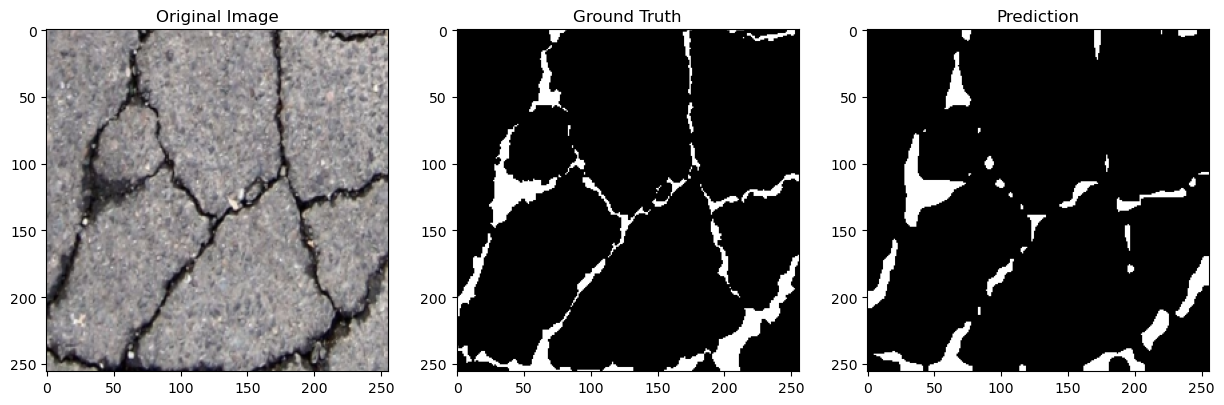

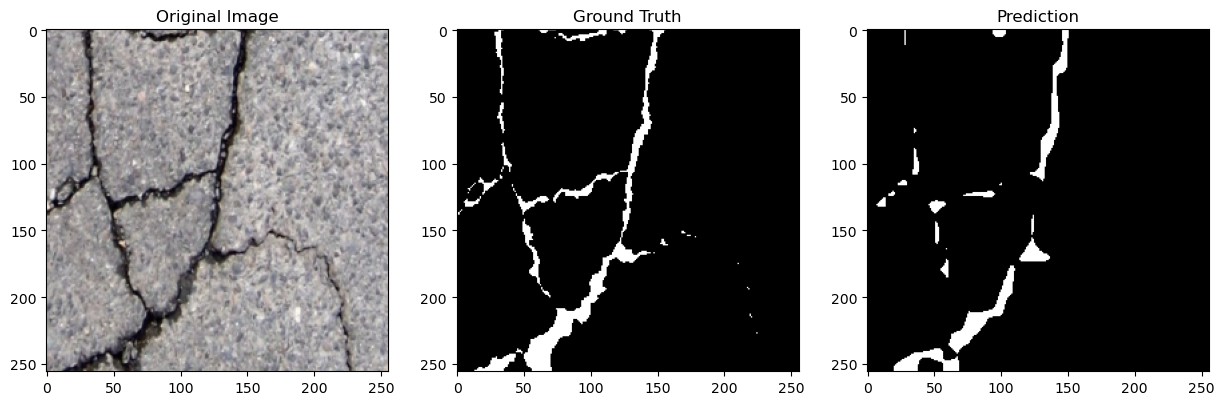

In [8]:
# evaluate the model
model.eval()
iou_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        intersection = torch.logical_and(masks, preds)
        union = torch.logical_or(masks, preds)
        iou_score = torch.sum(intersection) / torch.sum(union)
        iou_scores.append(iou_score.item())

mean_iou = np.mean(iou_scores)
print(f'Mean IoU: {mean_iou:.4f}')

# visualize the prediction
def visualize_prediction(image, mask, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # denormalize the image
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std[:, None, None] + mean[:, None, None]
    image = image.permute(1, 2, 0).numpy()
    
    ax1.imshow(image)
    ax1.set_title('Original Image')
    ax2.imshow(mask.cpu(), cmap='gray')
    ax2.set_title('Ground Truth')
    ax3.imshow(pred.cpu(), cmap='gray')
    ax3.set_title('Prediction')
    plt.show()

model.eval()
with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)['out']
        preds = torch.argmax(outputs, dim=1)
        
        for i in range(images.shape[0]):
            visualize_prediction(images[i].cpu(), masks[i].cpu(), preds[i].cpu())
        break